<a href="https://colab.research.google.com/github/ronald-hk-chung/ssnotebook/blob/main/computer_vision/rcnn_object_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training R-CNN-based object detectors

R-CNN stands for **Region-based Convolutional Neural Netowrk**. Region based Convolutional Neural Networks (R-CNNs) were initially presented by Girshick et. al. in their paper titled <a href="https://arxiv.org/abs/1311.2524">“Rich feature hierarchies for accurate object detection and semantic segmentation”</a> in 2013. R-CNN is a multi-stage object detection models which became the starting point for faster and more sophisticated variants in following years.

Below shows the main architecture of RCNN network

<img src='https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/rcnn_architecture.png?raw=true'>

<br/>

The R-CNN model is made up of four main components:

*   **Region Proposal:**
The extraction of regions of interest is the first and foremost step in this pipeline. The R-CNN model makes use of an algorithm called Selective Search for region proposal. Selective Search is a greedy search algorithm proposed by Uijlings et. al. in 2012. Without going into too many details, selective search makes use of a bottoms-up multi-scale iterative approach to identify ROIs. In every iteration the algorithm groups similar regions until the whole image is a single region. Similarity between regions is calculated based on color, texture, brightness etc. Selective search generates a lot of false positive (background) ROIs but has a high recall. The list of ROIs is passed onto the next step for processing.

<p align='center'><img src='https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/selective_search.png?raw=true'><p/>

<br/>

*   **Feature Extraction:**
The R-CNN network makes use of pre-trained CNNs such as VGGs or ResNets for extracting features from each of the ROIs identified in the previous step. Before the regions/crops are passed as inputs to the pre-trained network these are reshaped or warped to the required dimensions (each pretrained network requires inputs in specific dimensions only). The pre-trained network is used without the final classification layer. The output of this stage is a long list of tensors, one for each ROI from the previous stage.

<br/>

*   **Classification Head:**
The original R-CNN paper made use of Support Vector Machines (SVMs) as the classifier to identify the class of object in the ROI. SVM is a traditional supervised algorithm widely used for classification purposes. The output from this step is a classification label for every ROI.

<br/>

*   **Regression Head:**
This module takes care of the localization aspect of the object detection task. As discussed in the previous section, bounding boxes can be uniquely identified using 4 coordinates (top-left (x, y) coordinates along with width and height of the box). The regressor outputs these 4 values for every ROI.

<br/>

Below shows a summary overview of RCNN Network

<p align='center'><img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/rcnn_overview.png?raw=true"><p/>

## Notebook Preperation

In [1]:
!pip install -q git+https://github.com/ronald-hk-chung/sstorch.git

from sstorch.learner import SSTLearner
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download Dataset - Google Open Image v6 dataset

In [3]:
from google.colab import files
files.upload() # upload kaggle.json
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 69 Aug  8 14:08 kaggle.json
Dataset URL: https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks/versions/
License(s): unknown
 96% 353M/367M [00:03<00:00, 162MB/s]
100% 367M/367M [00:03<00:00, 116MB/s]


## Preparing the dataset

1. Fetch each image and its corresponding class and bounding box values
2. Fetching the region proposals within each image, their corresponding IoU, and teh delta by which the region proposal is to be corrected with respect to the ground truth
3. Assigning numeric labels for each class (where we have an additional background class besides the bus and truck classes) where IoU with the ground thruth bounding box is below a threshold
4. Resizing each region proposal to a common size in order to pass them to a network

By the end, we will have resized crops of region proposals, along with assigning the ground truth class to each region proposal, and claculated the offset of the region proposal in relation to the ground truth bounding box


In [4]:
IMAGE_ROOT = 'images/images'
DF_RAW = pd.read_csv('df.csv')
DF_RAW.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [5]:
len(DF_RAW['ImageID'].unique())

15225

`XMin`, `XMax`, `YMin`, `YMax` correspond to the ground truth of the bounding box of the image. `LabelName` provides the class of images

In [6]:
from PIL import Image
from torch.utils.data import Dataset

class OpenImages(Dataset):
  def __init__(self, df, image_folder):
    self.root = image_folder
    self.df = df
    self.unique_images = self.df['ImageID'].unique() #image can contain multiple objects
  def __len__(self):
    return len(self.unique_images)
  def __getitem__(self, idx):
    image_id = self.unique_images[idx]
    image_path = f'{self.root}/{image_id}.jpg'
    image = np.array(Image.open(image_path))
    h, w, _ = image.shape
    df = self.df[self.df['ImageID']==image_id]
    boxes = (df[['XMin','YMin', 'XMax', 'YMax']] * np.array([w, h, w, h])).astype(np.uint16).values.tolist()
    classes = df['LabelName'].values.tolist()
    return image, boxes, classes, image_path

ds = OpenImages(df=DF_RAW, image_folder=IMAGE_ROOT)

In [7]:
import matplotlib.patches as patches

def show_image(
    img: np.ndarray,
    bbs: list = None,
    bbs_format: str = "XYXY",
    bbs_label: list = None,
    color: str = "r",
):
    """Show Image

    Args:
        img (ndarray): image to show
        bbs (list): list bounding boxes
        bbs_format (str): bounding box format ('XYXY', 'XYWH', 'CXCYWH'), default to 'XYXY'
        bbs_label (list): list of bounding box label
        color (str): edgecolor of bounding box
    """
    fig, ax = plt.subplots()
    ax.imshow(img)
    if bbs is not None:
        for i, bb in enumerate(bbs):
            if bbs_format == "XYXY":
                x1, y1, x2, y2 = bb
                w, h = x2 - x1, y2 - y1
            elif bbs_format == "XYWH":
                x1, y1, w, h = bb
            elif bbs_format == "CXCYWH":
                cx, cy, w, h = bb
                x1 = cx - w / 2
                y1 = cy - h / 2
            rect = patches.Rectangle(
                (x1, y1), w, h, linewidth=1, edgecolor=color, facecolor="none"
            )
            ax.add_patch(rect)
            if bbs_label is not None:
                ax.annotate(bbs_label[i], (x1, y1), color=color)

    plt.axis(False)
    plt.show()

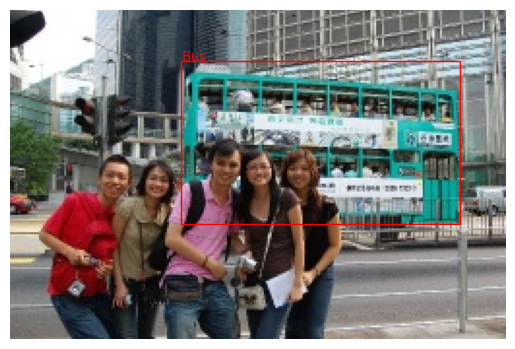

In [8]:
img, bbs, labels, path = ds[0]
show_image(img=img, bbs=bbs, bbs_label=labels, bbs_format='XYXY', color='r')

## Regional Proposal

Leveraging SelectiveSearch to generate region proposals. It is a region proposal algorithm used for object localizationw here it generates proposal of regions that are likely to be grouped together based on their pixel intensities SelectiveSearch groups pixels based on the heirarchical grouping of compatibility of content wihtin an image.

### Algorithm Of Selective Search:

Referece: http://www.huppelen.nl/publications/selectiveSearchDraft.pdf

1. Generate initial sub-segmentation of input image using the method describe by Felzenszwalb et al, implimented through ```skimage.segmentation.felzenszwalb``` (Referece: https://cs.brown.edu/people/pfelzens/papers/seg-ijcv.pdf)

2. Recursively combine the smaller similar regions into larger ones using below algorithm
> 1. From set of regions, choose two that are most similar
> 2. Combine them into a single, larger region
> 3. Repeat the above steps for multiple iteration

3. Use the segmented region proposals to generate candidate object locations

###Similarity in Segmentation

*   **Color Similarity**

> For each region we generate the histogram of each channels of colors present in image .In this paper 25 bins are taken in histogram of each color channel. This gives us 75 bins (25 for each R, G and B) and all channels are combined into a vector  (n = 75) for each region. Then we find similarity using equation below:

$$
\mathbf{S}_{\text {color }}\left(r_1, r_j\right)=\sum_{k=1}^n \min \left(c_i^k, r_j^k\right)
$$

*   **Texture Similarity**

> LBP (Local Binary Pattern) is used for texture classification. LBP looks at points surrounding a central point and tests whether the surrounding points are greater than or less than the central point (i.e. gives a binary result). Result is than extracted to a histogram with 10 bins for each color channels. We derive similarity using below equation:

$$
\mathbf{S}_{\text {texture }}\left(r_1, r_j\right)=\sum_{k=1}^n \min \left(c_i^k, r_j^k\right)
$$

*   **Size Similarity**

> The basic idea of size similarity is to make smaller region merge easily. If this similarity is not taken into consideration then larger region keep merging with larger region and region proposals at multiple scales will be generated at this location only.

$$
\mathbf{S}_{size}\left(\mathbf{r}_{\mathbf{i}}, \mathbf{r}_{\mathbf{j}}\right)=\mathbf{1}-\left(\operatorname{size}\left(\mathbf{r}_{\mathbf{i}}\right)+\operatorname{size}\left(\mathbf{r}_{\mathbf{j}}\right)\right) \div \operatorname{size}(\mathbf{i m g})
$$

*   **Fill Similarity**

> Fill Similarity measures how well two regions fit with each other. If two region fit well into one another (For Example one region is present in another) then they should be merged, if two region does not even touch each other then they should not be merged.

$$
\mathbf{S}_{\mathbf{f i l l}}\left(\mathbf{r}_{\mathbf{i}}, \mathbf{r}_{\mathbf{j}}\right)=\mathbf{1}-\left(\operatorname{size}\left(\mathbf{B B}_{\mathbf{i} \mathbf{j}}\right)-\operatorname{size}\left(\mathbf{r}_{\mathbf{i}}\right)-\operatorname{size}\left(\mathbf{r}_{\mathbf{j}}\right)\right) \div \operatorname{size}(\mathbf{i m g})
$$

$$
\text { size }\left(B B_{i j}\right) \text { is the size of bounding box around } i \text { and } j
$$

*   **Combine similarities to form a final similarity measure**

> Add all similarities measure using below formula:

$$
\mathbf{S}_{\left(\mathbf{r}_{\mathbf{i}}, \mathbf{r}_{\mathbf{j}}\right)}=\mathbf{a}_{\mathbf{1}} * \mathbf{s}_{\text {color }}\left(\mathbf{r}_{\mathbf{i}}, \mathbf{r}_{\mathbf{j}}\right)+\mathbf{a}_{\mathbf{2}} * \mathbf{s}_{\text {texture }}\left(\mathbf{r}_{\mathbf{i}}, \mathbf{r}_{\mathbf{j}}\right)+\mathbf{a}_3 * \mathbf{s}_{\text {size }}\left(\mathbf{r}_{\mathbf{i}}, \mathbf{r}_{\mathbf{j}}\right)+\mathbf{a}_{\mathbf{4}} * \mathbf{s}_{\text {fill }}\left(\mathbf{r}_{\mathbf{i}}, \mathbf{r}_{\mathbf{j}}\right)
$$
where $a_i$ is either 0 or 1 depending upon we consider this similarity or not .


### Reference:

https://www.geeksforgeeks.org/selective-search-for-object-detection-r-cnn/

http://www.huppelen.nl/publications/selectiveSearchDraft.pdf

http://vision.stanford.edu/teaching/cs231b_spring1415/slides/ssearch_schuyler.pdf

In [9]:
import skimage
from PIL import Image
import numpy as np

class SelectiveSearch:
    """Class performing Selective Search on image

    Args:
        scale (float): Free parameter. Higher means larger clusters in felzenszwalb segmentation
        sigma (float): Width of Gaussian kernel for felzenszwalb segmentation
        min_size (int): Minimum component size for felzenszwalb segmentation

    Methods:
        search(size_thresold=0.05): return list of bounding boxes as [x, y, w, h]
    """

    def __init__(
        self,
        img: Image.Image,
        scale: float = 1.0,
        sigma: float = 0.8,
        min_size: float = 100,
    ):
        self.img = np.array(img)
        self.scale = scale
        self.sigma = sigma
        self.min_size = min_size
        self.imsize = self.img.shape[0] * self.img.shape[1]
        self.im_mask = skimage.segmentation.felzenszwalb(
            image=skimage.util.img_as_float(self.img),
            scale=self.scale,
            sigma=self.sigma,
            min_size=self.min_size,
        )
        self.hsv = skimage.color.rgb2hsv(self.img)
        self.lbp = self.calc_texture_gradient()
        self.R = self.extract_region()
        self.neighbours = self.extract_neighbours()
        self.regions = self.hierarchal_search()

    def extract_region(self):
        R = {}
        # Generate initial sub-segmentation of input image using the method describe by Felzenszwalb
        for y in range(self.im_mask.shape[0]):
            for x in range(self.im_mask.shape[1]):
                if (l := self.im_mask[y][x]) not in R:
                    R[l] = {
                        "min_x": 0xFFFF,
                        "min_y": 0xFFFF,
                        "max_x": 0,
                        "max_y": 0,
                        "labels": [l],
                    }
                if R[l]["min_x"] > x:
                    R[l]["min_x"] = x
                if R[l]["min_y"] > y:
                    R[l]["min_y"] = y
                if R[l]["max_x"] < x:
                    R[l]["max_x"] = x
                if R[l]["max_y"] < y:
                    R[l]["max_y"] = y

        # Calculate colour and texture histogram for each region
        for l, v in list(R.items()):
            mask = self.im_mask == l
            R[l]["size"] = mask.sum()
            R[l]["hist_c"] = self.calc_colour_hist(mask)
            R[l]["hist_t"] = self.calc_texture_hist(mask)
        return R

    def calc_texture_gradient(self):
        """Calculate texture gradient for image using LBP
        Reference: https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.local_binary_pattern
        """
        ret = np.zeros(self.img.shape)
        for colour_channel in range(self.img.shape[2]):
            ret[:, :, colour_channel] = skimage.feature.local_binary_pattern(
                image=self.img[:, :, colour_channel],
                P=8,  # Number of circularly symmetric neighbor set points (quantization of the angular space)
                R=1.0,
            )  # Radius of circle (spatial resolution of the operator)
        return ret

    def calc_colour_hist(self, mask):
        """Calculate color histogram for each region
        The output will be an array with n_BINS * n_color_channels
        Extract from HSV
        """
        BINS = 25
        hist = np.array([])
        for colour_channel in range(self.img.shape[2]):
            layer = self.hsv[:, :, colour_channel][mask]
            hist = np.concatenate([hist] + [np.histogram(layer, BINS, (0.0, 255.0))[0]])
        # L1 normalize
        hist = hist / np.sum(hist)
        return hist

    def calc_texture_hist(self, mask):
        """Calculate texture histogram for each region
        Use LBP (AlpacaDB's implimentation)
        """
        BINS = 10
        hist = np.array([])
        for colour_channel in range(self.img.shape[2]):
            layer = self.lbp[:, :, colour_channel][mask]
            hist = np.concatenate([hist] + [np.histogram(layer, BINS, (0.0, 255.0))[0]])
        # L1 normalize
        hist = hist / np.sum(hist)
        return hist

    def extract_neighbours(self):
        def intersect(a, b):
            if (
                (
                    a["min_x"] < b["min_x"] < a["max_x"]
                    and a["min_y"] < b["min_y"] < a["max_y"]
                )
                or (
                    a["min_x"] < b["max_x"] < a["max_x"]
                    and a["min_y"] < b["max_y"] < a["max_y"]
                )
                or (
                    a["min_x"] < b["min_x"] < a["max_x"]
                    and a["min_y"] < b["max_y"] < a["max_y"]
                )
                or (
                    a["min_x"] < b["max_x"] < a["max_x"]
                    and a["min_y"] < b["min_y"] < a["max_y"]
                )
            ):
                return True
            return False

        R = list(self.R.items())
        neighbours = []
        for cur, a in enumerate(R[:-1]):
            for b in R[cur + 1 :]:
                if intersect(a[1], b[1]):
                    neighbours.append((a, b))
        return neighbours

    def calc_sim(self, r1, r2):
        """Calculate similarity between region ri and rj
        using diverse combinations of similarity measures.
        """
        sim_colour = self.calc_sim_colour(r1, r2)
        sim_texture = self.calc_sim_texture(r1, r2)
        sim_size = self.calc_sim_size(r1, r2)
        sim_fill = self.calc_sim_fill(r1, r2)
        return sim_colour + sim_texture + sim_size + sim_fill

    def calc_sim_colour(self, r1, r2):
        """Calculate the sum of hisogram intersection of colour"""
        return np.minimum(r1["hist_c"], r2["hist_c"]).sum()

    def calc_sim_texture(self, r1, r2):
        """Calculate texture similarity using histogram intersection"""
        return np.minimum(r1["hist_t"], r2["hist_t"]).sum()

    def calc_sim_size(self, r1, r2):
        """Size similarity boosts joint between small regions, which prevents
        a single region from engulfing other blobs one by one.
        size (ri, rj) = 1 − [size(ri) + size(rj)] / size(image)
        """
        return 1.0 - (r1["size"] + r2["size"]) / self.imsize

    def calc_sim_fill(self, r1, r2):
        """Fill similarity measures how well ri and rj fit into each other.
        BBij is the bounding box around ri and rj.
        fill(ri, rj) = 1 − [size(BBij) − size(ri) − size(ri)] / size(image)
        """
        x_fill = max(r1["max_x"], r2["max_x"]) - min(r1["min_x"], r2["min_x"])
        y_fill = max(r1["max_y"], r2["max_y"]) - min(r1["min_y"], r2["min_y"])
        bbsize = x_fill * y_fill
        return 1.0 - (bbsize - r1["size"] - r2["size"]) / self.imsize

    def merge_regions(self, r1, r2):
        ret = {
            "min_x": min(r1["min_x"], r2["min_x"]),
            "min_y": min(r1["min_y"], r2["min_y"]),
            "max_x": max(r1["max_x"], r2["max_x"]),
            "max_y": max(r1["max_y"], r2["max_y"]),
            "size": r1["size"] + r2["size"],
            "hist_c": (r1["hist_c"] * r1["size"] + r2["hist_c"] * r2["size"])
            / (r1["size"] + r2["size"]),
            "hist_t": (r1["hist_t"] * r1["size"] + r2["hist_t"] * r2["size"])
            / (r1["size"] + r2["size"]),
            "labels": r1["labels"] + r2["labels"],
        }
        return ret

    def hierarchal_search(self):
        # calculate initial similarities
        S = {}
        for (ai, ar), (bi, br) in self.neighbours:
            S[(ai, bi)] = self.calc_sim(ar, br)
        # hierarchal search
        while S != {}:
            # get highest similarity
            i, j = sorted(S.items(), key=lambda x: x[1])[-1][0]
            # merge corresponding regions
            t = max(self.R.keys()) + 1.0
            self.R[t] = self.merge_regions(self.R[i], self.R[j])
            # mark similarities for regions to be removed
            key_to_delete = [k for k, v in list(S.items()) if (i in k) or (j in k)]
            # remove old similarities of related regions
            for k in key_to_delete:
                del S[k]
            # calculate similary set with the new region
            for k in filter(lambda x: x != (i, j), key_to_delete):
                n = k[1] if k[0] in (i, j) else k[0]
                S[(t, n)] = self.calc_sim(self.R[t], self.R[n])
        regions = []
        for k, r in list(self.R.items()):
            regions.append(
                {
                    "rect": (
                        r["min_x"],
                        r["min_y"],
                        r["max_x"] - r["min_x"],
                        r["max_y"] - r["min_y"],
                    ),
                    "size": r["size"],
                    "labels": r["labels"],
                }
            )
        return regions

    def search(self, size_thresold: float = 0.05, format: str = "XYWH"):
        """Method to perform selective search

        Args:
          size_thresold (float): thresold as percentage of image

        Return:
          candidates (list): list of bounding boxes as [x, y, w, h]
        """
        candidates = []
        for r in self.regions:
            if r["rect"] in candidates:
                continue
            if r["size"] < (size_thresold * self.imsize):
                continue
            if r["size"] > self.imsize:
                continue
            candidates.append(list(r["rect"]))

        if format == "XYXY":
            candidates = [(x, y, x + w, y + h) for x, y, w, h in candidates]
        elif format == "CXCYWH":
            candidates = [(x + w / 2, y + h / 2, w, h) for x, y, w, h in candidates]
        return candidates


No of Candidates: 50


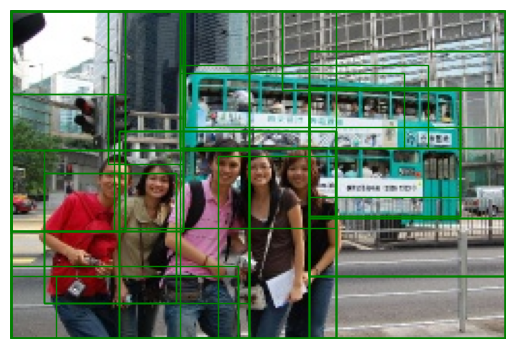

In [10]:
img_search = SelectiveSearch(img=img, scale=200, min_size=100)
candidates = img_search.search(size_thresold=0.05, format='XYWH')
print(f'No of Candidates: {len(candidates)}')
show_image(img=img, bbs=candidates, bbs_format='XYWH', color='g')

## Define IOU function

Intersection over Union *IoU* is used to measure the accuracy of bounding box prediction.

*Intersection* measures how overalapping the predicted and actual bounding boxes are, while *Union* measures the overall space possible for overlap. *IoU* is the ratio of the overlapping region between the two bounding boxes over the combined region of both the bounding boxes

<img src='https://miro.medium.com/v2/resize:fit:640/format:webp/1*r0o3vX-x979Q84_lbJWS_g.jpeg'>

In [11]:
def extract_iou(boxA: list, boxB: list, epsilon: float = 1e-5) -> float:
    """Calculate Intersection of Unions

    Args:
      boxA [list]: bounding box in format of 'XYXY'
      boxB [list]: bounding box in format of 'XYXY'
      epsilon [float]: smooth factor to avoid division by 0, default o 1e-5

    Return:
      iou [float]: intersection of unions
    """
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = x2 - x1
    height = y2 - y1
    if width < 0 and height < 0:
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined + epsilon)  # smooth devision to avoid 0/0
    return iou

## Preparing region proposals and the ground truth of offset

Creating the input and output values correspond to R-CNN model:

- input constitutes the candidates that are extracted using the *Selective Search* using selectivesearch algo

- output constitutes the class corresponding to candidates and the offset of the candidate with respect to the bounding box it overlaps and most with if the candidate contains an object

In [12]:
from tqdm.auto import tqdm

data = []
N = 10000
pbar = tqdm(total = N)
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break
    # Extract candidates from each image in absolute pixel values
    H, W, _ = im.shape
    img_search = SelectiveSearch(img=im, scale=200, min_size=100)
    candidates = img_search.search(size_thresold=0.05, format='XYXY')

    # Initialise data_dict to hold
    # ious (Intersection over Union),
    # rois (Region of Interest),
    # clss (Class) and
    # delta (difference between proposal and ground truth)
    data_dict = {}
    rois, clss, deltas = [], [], []

    # Calculate ious comparing candidates to bbs (ground truth)
    ious = np.array([[extract_iou(candidate, bb) for candidate in candidates] for bb in bbs]).T

    for jx, candidate in enumerate(candidates):
        cx1,cy1,cx2,cy2 = candidate
        candidate_ious = ious[jx] # Get candidate ious
        # Find the index of candidate that has the highest IoU and correponding gound truth (best_bb)
        best_iou_index = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_index]
        best_bb = x1, y1, x2, y2 = bbs[best_iou_index]
        # If IoU (best_iou) is greater than a thresold(0.3), assign label of class, otherwise assign 'background'
        clss.append(labels[best_iou_index]) if best_iou > 0.3 else clss.append('Background')
        # Fetch offset needed (deltas) to transform current proposal into the candidate that is the best region proposal (best_bb)
        delta = np.array([x1-cx1, y1-cy1, x2-cx2, y2-cy2]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))

    # put fpath, ious, rois, clss, deltas and bbs(as gtbbs) in data_dict and append to data
    data_dict['fpaths'] = fpath
    data_dict['ious'] = ious # intersection of unions result
    data_dict['rois'] = rois # regional proposal locations
    data_dict['clss'] = clss # class of bounding box
    data_dict['deltas'] = deltas # offset of ground_truth bounding box - candidate bounding box relative to image size
    data_dict['gtbbs'] = bbs # ground truth bounding box
    data.append(data_dict)
    pbar.update(1)
pbar.close()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
# savedown data into rcnn_data.pt
import pickle
# with open('drive/MyDrive/ssmodel/rcnn_data.pkl', 'wb') as f:
#   pickle.dump(data, f)
with open('drive/MyDrive/ssmodel/rcnn_data.pkl', 'rb') as f:
  data = pickle.load(f)

In [13]:
data[0]

{'fpaths': 'images/images/0000599864fd15b3.jpg',
 'ious': array([[ 0.36111111],
        [-0.12881784],
        [-0.10659425],
        [-0.04928558],
        [-0.00466228],
        [-0.00466228],
        [ 0.27371156],
        [ 0.08943037],
        [ 0.36959209],
        [-0.04710341],
        [ 0.00309598],
        [ 0.42559524],
        [ 0.44987231],
        [-0.11459215],
        [ 0.00350436],
        [ 0.42559524],
        [ 0.13603058],
        [ 0.01291106],
        [ 0.01291106],
        [ 0.06948798],
        [-0.11459215],
        [ 0.00379096],
        [ 0.01291106],
        [ 0.42559524],
        [ 0.08943037],
        [ 0.33225826],
        [ 0.28122088],
        [ 0.01291106],
        [-0.03739085],
        [ 0.18972332],
        [ 0.36935704],
        [ 0.36935704],
        [ 0.33225826],
        [ 0.05859805],
        [ 0.33225826],
        [ 0.37960603],
        [ 0.05859805],
        [ 0.00379096],
        [ 0.00379096],
        [ 0.05859805],
        [ 0.37960603],


In [14]:
# Convert clss into their corresponding indices
# background 0, Bus 1, Truck 2
classes = sorted(set([item for data_dict in data for item in data_dict['clss']]))
label2target = {k : v for v, k in enumerate(classes)}
target2label = {v : k for k, v in label2target.items()}
print(label2target)
print(target2label)

{'Background': 0, 'Bus': 1, 'Truck': 2}
{0: 'Background', 1: 'Bus', 2: 'Truck'}


## Define Dataset and DataLoader for RCNN

In [15]:
import torch
from torchvision.transforms import v2 as T
tfms = T.Compose([T.ToImage(),
                  T.ToDtype(torch.float32, scale=True),
                  T.Resize(size=(224, 224), antialias=True),
                  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)])

In [16]:
class RCNNDataset(Dataset):
  def __init__(self, data):
    self.data = data
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    fpath = self.data[idx]['fpaths']
    image = np.array(Image.open(fpath))
    H, W, C = image.shape
    sh = np.array([W, H, W, H])
    gtbbs = self.data[idx]['gtbbs']
    rois = self.data[idx]['rois']
    bbs = (np.array(rois) * sh).astype(np.uint16)
    labels = self.data[idx]['clss']
    deltas = self.data[idx]['deltas']
    crops = [image[y1:y2, x1:x2] for (x1, y1, x2, y2) in bbs]
    return image, crops, bbs, labels, deltas, gtbbs, fpath
  def collate_fn(self, batch):
    input = []
    rois = []
    rixs = []
    labels = []
    deltas = []
    for idx in range(len(batch)):
      image, image_crops, image_bbs, image_labels, image_deltas, image_gtbbs, image_fpath = batch[idx]
      input += [tfms(crop.copy()) for crop in image_crops]
      labels += [label2target[c] for c in image_labels]
      deltas += image_deltas
    input = torch.stack(input, dim=0)
    clss = torch.Tensor(np.array(labels)).long()
    deltas = torch.Tensor(np.array(deltas)).float()
    return input, {'clss': clss, 'deltas': deltas}

In [18]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
data_train, data_valid = train_test_split(data, test_size=0.1)

train_ds = RCNNDataset(data=data_train)
valid_ds = RCNNDataset(data=data_valid)

train_dl = DataLoader(dataset=train_ds,
                      batch_size=64,
                      collate_fn=train_ds.collate_fn,
                      shuffle=True,
                      drop_last=True)

valid_dl = DataLoader(dataset=valid_ds,
                      batch_size=64,
                      collate_fn=valid_ds.collate_fn,
                      shuffle=False,
                      drop_last=True)

## Modify Resnet50 classifier that can predict both the cass of region proposal and the offset corresponding to it in order ot draw a tight bounding box around the objet in the image

1. Define Resnet backbone
2. Fetch the features post passing the normalized crop through a pretrained model
3. Attach a linear layer with sigmoid activation to the Resnet backbone to predict the class corresponding to the regional proposal
4. Attach an additional linear layer to predict the four bounding box offsets
5. Define the loss calculations for each of the two outputs (one to predict classa nd the other to predict the four bounding box offsets)
6. Train the model that predicts both the class of region proposal and the four bounding box offsets

In [19]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]


In [20]:
# Define model from resnet50 Backbone
# Attach linear lyaer predict the class
# Attach additional linear layer to predict 4 bounding box offsets

from torch import nn

class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 2048
        self.backbone = nn.Sequential(*list(model.children())[:-1],
                                      nn.Flatten())
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(nn.Linear(feature_dim, 512),
                                  nn.ReLU(),
                                  nn.Linear(512, 4),
                                  nn.Tanh())
    def forward(self, input):
        feature = self.backbone(input)
        cls_score = self.cls_score(feature)
        bbox = self.bbox(feature)
        return {'clss_score': cls_score,
                'bbox': bbox}

rcnn = RCNN()

In [21]:
class RCNNLoss:
  def __init__(self):
    self.detection_loss = nn.CrossEntropyLoss()
    self.regression_loss = nn.L1Loss()
  def __call__(self, y_logits, y):
    detection_loss = self.detection_loss(y_logits['clss_score'], y['clss'])
    ixs = torch.where(y['clss'] != 0)
    if len(ixs) > 0:
      regression_loss = self.regression_loss(y_logits['bbox'][ixs], y['deltas'][ixs])
      if torch.isnan(regression_loss):
        regression_loss = 0
    else:
      regression_loss = 0
    return detection_loss + 10 * regression_loss

loss_fn = RCNNLoss()

In [22]:
class RCNNMetric:
  def __init__(self):
    self.detection_loss = nn.CrossEntropyLoss()
    self.regression_loss = nn.L1Loss()
  def __call__(self, y_logits, y):
    # detection_loss = self.detection_loss(y_logits[0], y[0]).cpu().detach().numpy()
    detection_loss = self.detection_loss(y_logits['clss_score'], y['clss']).cpu().detach().numpy()
    detection_acc = sum(y_logits['clss_score'].argmax(dim=1) == y['clss']).item() / len(y['clss'])
    ixs = torch.where(y['clss'] != 0)
    if len(ixs) > 0:
        # regression_loss = self.regression_loss(y_logits[1][ixs], y[1][ixs]).cpu().detach().numpy()
        regression_loss = self.regression_loss(y_logits['bbox'][ixs], y['deltas'][ixs]).cpu().detach().numpy()
        if np.isnan(regression_loss):
            regression_loss = 0
    else:
        regression_loss = 0

    # return detection_loss, detection_acc, (0 if np.isnan(regression_loss) else regression_loss)
    return {
        'detection_loss': detection_loss,
        'detection_acc': detection_acc,
        'regression_loss': 0 if np.isnan(regression_loss) else regression_loss
        }

metric_fn = RCNNMetric()

In [23]:
# Define optimizer
optimizer = torch.optim.AdamW(params=rcnn.parameters(), lr=1e-3)

In [24]:
RCNNDetector = SSTLearner(model=rcnn,
                          loss_fn=loss_fn,
                          metric_fn=metric_fn,
                          optimizer=optimizer,
                          train_dataloader=train_dl,
                          valid_dataloader=valid_dl)

In [25]:
RCNNDetector.freeze(['backbone'])

In [26]:
RCNNDetector.model_info()

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
RCNN (RCNN)                                   [2387, 3, 224, 224]  [2387, 4]            --                   Partial
├─Sequential (backbone)                       [2387, 3, 224, 224]  [2387, 2048]         --                   False
│    └─Conv2d (0)                             [2387, 3, 224, 224]  [2387, 64, 112, 112] (9,408)              False
│    └─BatchNorm2d (1)                        [2387, 64, 112, 112] [2387, 64, 112, 112] (128)                False
│    └─ReLU (2)                               [2387, 64, 112, 112] [2387, 64, 112, 112] --                   --
│    └─MaxPool2d (3)                          [2387, 64, 112, 112] [2387, 64, 56, 56]   --                   --
│    └─Sequential (4)                         [2387, 64, 56, 56]   [2387, 256, 56, 56]  --                   False
│    │    └─Bottleneck (0)                    [2387, 64, 56, 56]   [2387, 256, 5

In [45]:
RCNNDetector.train(2)

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 4 | LR: 1.0E-03 | train_loss: 1.236 | valid_loss: 1.298 
train_metric: {'detection_loss': 0.424, 'detection_acc': 0.832, 'regression_loss': 0.081}
valid_metric: {'detection_loss': 0.439, 'detection_acc': 0.825, 'regression_loss': 0.086}
----------------------------------------------------------------------------------------------------
Epoch: 5 | LR: 1.0E-03 | train_loss: 1.211 | valid_loss: 1.286 
train_metric: {'detection_loss': 0.415, 'detection_acc': 0.835, 'regression_loss': 0.08}
valid_metric: {'detection_loss': 0.432, 'detection_acc': 0.827, 'regression_loss': 0.085}
----------------------------------------------------------------------------------------------------


## Predict on a new image
To predict and draw bounding boxes around objects and the corresponding class of object within the predicted bounding box on new image

1. Extract region proposals from new image
2. Resize and normalize each crop
3. Feed-forward the processed crops to make predictions of class and the offsets
4. Perform non-max suppression to fetch only those boxes that have the highest confidence

## Non-max suppression

Non-supression is used to solve the problem where multiple region proposals are generated and significantly overlap one another.

*Non-max* refers to the boxes that do not contain the highest probability of containing an object, and suppression refers to us discarding those boxes that do not contain the highest probabilities of containing an object. In non-max suppression, we identify the bounding boxes that has the highest probability and discard all the other bounding boxes that have an IoU greater than a certain threshold with the box containing the highest probability of contianing an object

In Pytorch, non-max suppression is performed using the `nms` function in the `torchvision.ops` module. The `nms` function takes the bounding box coordinates, the confidence of the object in teh boudning box, and the threshold of IoU across bounding boxes, to identify the boudning boxes to be retained.

In [46]:
from torchvision.ops import nms

def rcnn_inference(fname: str):
    #   img = cv2.imread(fname, cv2.IMREAD_COLOR)[:,:,::-1]
    img = np.array(Image.open(fname))
    img_search = SelectiveSearch(img=img, scale=200, min_size=100)
    candidates = img_search.search(size_thresold=0.05, format='XYXY')

    input=[]
    for candidate in candidates:
        x1, y1, x2, y2 = candidate
        crop = img[y1:y2, x1:x2]
        input.append(tfms(crop.copy()))
    input = torch.stack(input, dim=0)
    # Make predictions using model to get probs and deltas
    with torch.inference_mode():
        RCNNDetector.model.to('cpu')
        preds = RCNNDetector.model(input)
        probs = preds['clss_score']
        deltas = preds['bbox']
    # Turn probs into probabilities of class using softmax and get max prob clss
    probs = torch.nn.functional.softmax(probs, -1)
    confs, clss = torch.max(probs, -1)
    # Turn tensor into numpy for filtering operation for non-background indices
    candidates = np.array(candidates)
    confs, clss, probs, deltas,  = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]
    # Filter out Background clss
    nb_idx = clss != label2target['Background']
    confs, clss, probs, deltas, candidates = [tensor[nb_idx] for tensor in [confs, clss, probs, deltas, candidates]]
    # For bounding box (bbs) with deltas and candidates
    bbs = (candidates + deltas).astype(np.uint16)
    # Perform non-max suppression and perform filtering on nms_idx https://pytorch.org/vision/main/generated/torchvision.ops.nms.html
    nms_idx = nms(boxes=torch.tensor(bbs.astype(np.float32)),
                    scores=torch.tensor(confs),
                    iou_threshold=0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[nms_idx] for tensor in [confs, clss, probs, deltas, candidates, bbs]]

    if len(nms_idx) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bbs = bbs[best_pred]
        x1, y1, x2, y2 = best_bbs
        show_image(img=img, bbs=bbs, bbs_label=[target2label[clss[best_pred]]], bbs_format='XYXY', color='r')
        return best_bbs, target2label[clss[best_pred]],best_conf
    else:
        show_image(img=img)
        return (0,0,224,224), 'Background', 0

In [47]:
import requests
url = 'https://fft-keybuses.b-cdn.net/sites/busesmag/files/styles/article_body/public/imported/2021-01-12/img_40-2.jpg?itok=kQSKw6Gv'
with open('bus.jpg', 'wb') as f:
  f.write(requests.get(url).content)

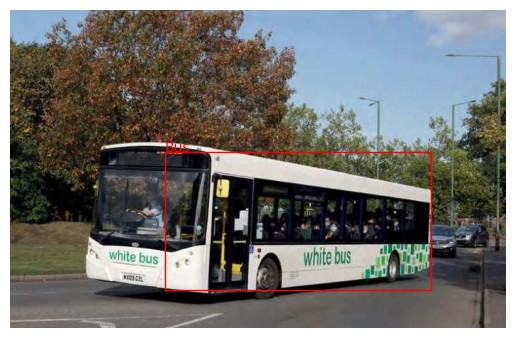

(array([218, 200, 593, 395], dtype=uint16), 'Bus', 0.98172325)

In [48]:
rcnn_inference('bus.jpg')

In [51]:
url='https://cvimg1.cardekho.com/p/630x420/in/tata/407-gold-sfc/tata-407-gold-sfc-15836.jpg?impolicy=resize&imwidth=420'
with open('truck.jpg', 'wb') as f:
  f.write(requests.get(url).content)

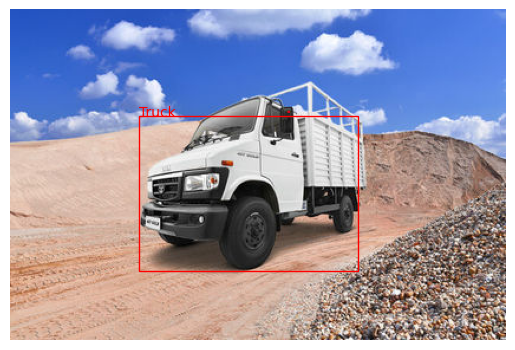

(array([109,  90, 294, 221], dtype=uint16), 'Truck', 0.95945346)

In [52]:
rcnn_inference('truck.jpg')